In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

(112, 35)


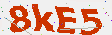

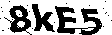

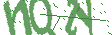

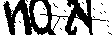

In [2]:
from captchagen import get_captcha_image, generate_captcha, preprocess_image
# 示例使用
image, cookie = get_captcha_image()

# image info
print(image.size)
# show image
from IPython.display import display

display(image)
display(preprocess_image(image))

image, captcha = generate_captcha()
display(image)
display(preprocess_image(image))

In [6]:
import torch
from models.cnn import CaptchaOCR
model = CaptchaOCR().to(device)
import os

if os.path.exists("captcha_ocr.pth"):
    model.load_state_dict(torch.load("captcha_ocr.pth"))

/tmp/ipykernel_1056577/1488443610.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("captcha_ocr.pth"))


In [3]:
from models.transformer import CaptchaSolverWithTransformer
model = CaptchaSolverWithTransformer().to(device)
import os

if os.path.exists("captcha_transformer.pth"):
    model.load_state_dict(torch.load("captcha_transformer.pth"))

/home/caoziguang/miniconda3/envs/captcha/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/tmp/ipykernel_1203494/4085151542.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed t

In [13]:
from models.cnn_transformer import CaptchaSolverWithCNNTransformer

model = CaptchaSolverWithCNNTransformer().to(device)
import os

# if os.path.exists("captcha_cnn_transformer.pth"):
#     model.load_state_dict(torch.load("captcha_cnn_transformer.pth"))

/home/cao/miniconda3/envs/pytorch/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [22]:
from models.resnet import ResNetCaptchaOCR

model = ResNetCaptchaOCR().to(device)
import os

if os.path.exists("captcha_resnet.pth"):
    model.load_state_dict(torch.load("captcha_resnet.pth"))

In [41]:
# save model
def save_model(model):
    if model.__class__.__name__ == "CaptchaOCR":
        torch.save(model.state_dict(), "captcha_ocr.pth")
    elif model.__class__.__name__ == "CaptchaSolverWithTransformer":
        torch.save(model.state_dict(), "captcha_transformer.pth")
    elif model.__class__.__name__ == "ResNetCaptchaOCR":
        torch.save(model.state_dict(), "captcha_resnet.pth")

In [46]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(f"runs/{model.__class__.__name__}")
last_epoch = 0

In [48]:
from torch.utils.data import DataLoader
from dataset import CaptchaDataset

dataset = CaptchaDataset(10000,repeat=10)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, drop_last=True)

test_dataset = CaptchaDataset(100)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True, drop_last=True)


100%|██████████| 100/100 [00:00<00:00, 507.25it/s]


In [49]:
# train model
import torch
import torch.optim as optim
from tqdm import tqdm

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

for epoch in range(last_epoch, 100+last_epoch):
    last_epoch = epoch
    for x, y in tqdm(dataloader):
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        loss = criterion(y_pred.view(-1, 62), y.argmax(dim=-1).view(-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    accuracy = (y_pred.argmax(dim=-1) == y.argmax(dim=-1)).float().mean()
    tqdm.write(f"epoch: {epoch}, loss: {loss.item()}, accuracy: {accuracy.item()}")

    with torch.no_grad():
        total_loss = 0
        total_accuracy = 0
        for x, y in test_dataloader:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            total_loss += criterion(y_pred.view(-1, 62), y.argmax(dim=-1).view(-1)).item()
            total_accuracy += (y_pred.argmax(dim=-1) == y.argmax(dim=-1)).float().mean().item()
        total_loss /= len(test_dataloader)
        tqdm.write(f"test loss: {total_loss}, test accuracy: {total_accuracy / len(test_dataloader)}")
    writer.add_scalars("loss", {
        "train": loss.item(),
        "test": total_loss
    }, epoch)
    writer.add_scalars("accuracy", {
        "train": accuracy.item(),
        "test": total_accuracy / len(test_dataloader)
    }, epoch)
    save_model(model)
    

  0%|          | 0/312 [00:00<?, ?it/s]

100%|██████████| 312/312 [01:18<00:00,  3.97it/s]


epoch: 0, loss: 3.766529083251953, accuracy: 0.09375
test loss: 3.8331010341644287, test accuracy: 0.059895833333333336


100%|██████████| 312/312 [01:17<00:00,  4.04it/s]


epoch: 1, loss: 3.664557456970215, accuracy: 0.125
test loss: 3.871846834818522, test accuracy: 0.033854166666666664


100%|██████████| 312/312 [01:20<00:00,  3.90it/s]


epoch: 2, loss: 3.649022340774536, accuracy: 0.09375
test loss: 3.8455288410186768, test accuracy: 0.0625


100%|██████████| 312/312 [01:21<00:00,  3.85it/s]


epoch: 3, loss: 3.5746426582336426, accuracy: 0.109375
test loss: 3.860151529312134, test accuracy: 0.049479166666666664


100%|██████████| 312/312 [01:17<00:00,  4.03it/s]


epoch: 4, loss: 3.605220317840576, accuracy: 0.125
test loss: 3.857389052708944, test accuracy: 0.057291666666666664


100%|██████████| 312/312 [01:25<00:00,  3.65it/s]


epoch: 5, loss: 3.5830225944519043, accuracy: 0.109375
test loss: 3.8608900705973306, test accuracy: 0.0703125


100%|██████████| 312/312 [01:17<00:00,  4.05it/s]


epoch: 6, loss: 3.542928695678711, accuracy: 0.109375
test loss: 3.8472096920013428, test accuracy: 0.057291666666666664


100%|██████████| 312/312 [01:13<00:00,  4.26it/s]


epoch: 7, loss: 3.5464141368865967, accuracy: 0.0859375
test loss: 3.8310038248697915, test accuracy: 0.078125


100%|██████████| 312/312 [01:15<00:00,  4.11it/s]


epoch: 8, loss: 3.5655434131622314, accuracy: 0.1171875
test loss: 3.8267269929250083, test accuracy: 0.059895833333333336


100%|██████████| 312/312 [01:21<00:00,  3.81it/s]


epoch: 9, loss: 3.373478651046753, accuracy: 0.109375
test loss: 3.8415819803873696, test accuracy: 0.07291666666666667


100%|██████████| 312/312 [01:19<00:00,  3.93it/s]


epoch: 10, loss: 3.547436475753784, accuracy: 0.1171875
test loss: 3.844132343928019, test accuracy: 0.057291666666666664


100%|██████████| 312/312 [01:13<00:00,  4.27it/s]


epoch: 11, loss: 3.4557743072509766, accuracy: 0.125
test loss: 3.8601576487223306, test accuracy: 0.0703125


100%|██████████| 312/312 [01:13<00:00,  4.23it/s]


epoch: 12, loss: 3.4465103149414062, accuracy: 0.1328125
test loss: 3.841637929280599, test accuracy: 0.078125


100%|██████████| 312/312 [01:11<00:00,  4.34it/s]


epoch: 13, loss: 3.5633544921875, accuracy: 0.1171875
test loss: 3.808854103088379, test accuracy: 0.07552083333333333


100%|██████████| 312/312 [01:10<00:00,  4.43it/s]


epoch: 14, loss: 3.3492743968963623, accuracy: 0.1640625
test loss: 3.860507090886434, test accuracy: 0.057291666666666664


100%|██████████| 312/312 [01:16<00:00,  4.08it/s]


epoch: 15, loss: 3.4030649662017822, accuracy: 0.1484375
test loss: 3.789914846420288, test accuracy: 0.06770833333333333


100%|██████████| 312/312 [01:21<00:00,  3.85it/s]


epoch: 16, loss: 3.3596112728118896, accuracy: 0.125
test loss: 3.7783214251200357, test accuracy: 0.07291666666666667


100%|██████████| 312/312 [01:17<00:00,  4.04it/s]


epoch: 17, loss: 3.3775691986083984, accuracy: 0.2109375
test loss: 3.8171047369639077, test accuracy: 0.09895833333333333


100%|██████████| 312/312 [01:16<00:00,  4.09it/s]


epoch: 18, loss: 3.3367443084716797, accuracy: 0.1796875
test loss: 3.8001981576283774, test accuracy: 0.07552083333333333


100%|██████████| 312/312 [01:14<00:00,  4.17it/s]


epoch: 19, loss: 3.5695817470550537, accuracy: 0.109375
test loss: 3.7536373138427734, test accuracy: 0.06510416666666667


100%|██████████| 312/312 [01:13<00:00,  4.24it/s]


epoch: 20, loss: 3.1626505851745605, accuracy: 0.1875
test loss: 3.766343911488851, test accuracy: 0.07552083333333333


100%|██████████| 312/312 [01:18<00:00,  3.98it/s]


epoch: 21, loss: 3.342641830444336, accuracy: 0.1484375
test loss: 3.751601298650106, test accuracy: 0.10416666666666667


100%|██████████| 312/312 [01:19<00:00,  3.94it/s]


epoch: 22, loss: 3.113023281097412, accuracy: 0.21875
test loss: 3.801513910293579, test accuracy: 0.109375


100%|██████████| 312/312 [01:27<00:00,  3.57it/s]


epoch: 23, loss: 3.33791184425354, accuracy: 0.109375
test loss: 3.7557058334350586, test accuracy: 0.09895833333333333


100%|██████████| 312/312 [01:18<00:00,  3.97it/s]


epoch: 24, loss: 3.2899270057678223, accuracy: 0.203125
test loss: 3.7450756231943765, test accuracy: 0.0859375


100%|██████████| 312/312 [01:23<00:00,  3.74it/s]


epoch: 25, loss: 3.4248170852661133, accuracy: 0.171875
test loss: 3.768491188685099, test accuracy: 0.09895833333333333


100%|██████████| 312/312 [01:29<00:00,  3.50it/s]


epoch: 26, loss: 3.235828399658203, accuracy: 0.1484375
test loss: 3.694310426712036, test accuracy: 0.1171875


100%|██████████| 312/312 [01:13<00:00,  4.23it/s]


epoch: 27, loss: 3.2717888355255127, accuracy: 0.203125
test loss: 3.696357806523641, test accuracy: 0.10677083333333333


100%|██████████| 312/312 [01:15<00:00,  4.15it/s]


epoch: 28, loss: 3.0870518684387207, accuracy: 0.2421875
test loss: 3.7051539421081543, test accuracy: 0.09895833333333333


100%|██████████| 312/312 [01:17<00:00,  4.00it/s]


epoch: 29, loss: 3.2076454162597656, accuracy: 0.21875
test loss: 3.6883649031321206, test accuracy: 0.11979166666666667


100%|██████████| 312/312 [01:19<00:00,  3.92it/s]


epoch: 30, loss: 3.098982810974121, accuracy: 0.171875
test loss: 3.6811766624450684, test accuracy: 0.12239583333333333


100%|██████████| 312/312 [01:17<00:00,  4.01it/s]


epoch: 31, loss: 3.3522913455963135, accuracy: 0.1796875
test loss: 3.667339007059733, test accuracy: 0.13020833333333334


100%|██████████| 312/312 [01:32<00:00,  3.37it/s]


epoch: 32, loss: 2.961519956588745, accuracy: 0.265625
test loss: 3.722814162572225, test accuracy: 0.125


100%|██████████| 312/312 [01:52<00:00,  2.77it/s]


epoch: 33, loss: 2.922961473464966, accuracy: 0.2421875
test loss: 3.7141350905100503, test accuracy: 0.09895833333333333


100%|██████████| 312/312 [01:31<00:00,  3.43it/s]


epoch: 34, loss: 3.1288702487945557, accuracy: 0.234375
test loss: 3.7311557133992515, test accuracy: 0.12760416666666666


100%|██████████| 312/312 [01:21<00:00,  3.83it/s]


epoch: 35, loss: 3.2627367973327637, accuracy: 0.2265625
test loss: 3.6362303098042807, test accuracy: 0.1171875


100%|██████████| 312/312 [01:19<00:00,  3.92it/s]


epoch: 36, loss: 2.950387954711914, accuracy: 0.2578125
test loss: 3.6305367151896157, test accuracy: 0.13020833333333334


100%|██████████| 312/312 [01:17<00:00,  4.03it/s]


epoch: 37, loss: 2.948321580886841, accuracy: 0.3203125
test loss: 3.6814839045206704, test accuracy: 0.12760416666666666


100%|██████████| 312/312 [01:18<00:00,  3.99it/s]


epoch: 38, loss: 3.1107728481292725, accuracy: 0.1875
test loss: 3.691166877746582, test accuracy: 0.12760416666666666


100%|██████████| 312/312 [01:15<00:00,  4.12it/s]


epoch: 39, loss: 2.9499094486236572, accuracy: 0.28125
test loss: 3.606473525365194, test accuracy: 0.13541666666666666


100%|██████████| 312/312 [01:16<00:00,  4.08it/s]


epoch: 40, loss: 3.1704471111297607, accuracy: 0.2109375
test loss: 3.6717918713887534, test accuracy: 0.1328125


100%|██████████| 312/312 [01:16<00:00,  4.05it/s]


epoch: 41, loss: 2.948962926864624, accuracy: 0.2578125
test loss: 3.68208376566569, test accuracy: 0.13020833333333334


100%|██████████| 312/312 [01:12<00:00,  4.28it/s]


epoch: 42, loss: 3.1753087043762207, accuracy: 0.2265625
test loss: 3.6699768702189126, test accuracy: 0.1328125


100%|██████████| 312/312 [01:18<00:00,  3.96it/s]


epoch: 43, loss: 2.9892759323120117, accuracy: 0.25
test loss: 3.668490409851074, test accuracy: 0.12760416666666666


100%|██████████| 312/312 [01:15<00:00,  4.14it/s]


epoch: 44, loss: 2.9713611602783203, accuracy: 0.2890625
test loss: 3.696119705835978, test accuracy: 0.125


100%|██████████| 312/312 [01:20<00:00,  3.88it/s]


epoch: 45, loss: 2.765036106109619, accuracy: 0.375
test loss: 3.592684825261434, test accuracy: 0.15625


100%|██████████| 312/312 [01:16<00:00,  4.07it/s]


epoch: 46, loss: 2.858520269393921, accuracy: 0.3203125
test loss: 3.6694653034210205, test accuracy: 0.12760416666666666


100%|██████████| 312/312 [01:18<00:00,  3.96it/s]


epoch: 47, loss: 3.025970935821533, accuracy: 0.2421875
test loss: 3.632842222849528, test accuracy: 0.1484375


100%|██████████| 312/312 [01:16<00:00,  4.10it/s]


epoch: 48, loss: 2.932008981704712, accuracy: 0.28125
test loss: 3.692605495452881, test accuracy: 0.13541666666666666


100%|██████████| 312/312 [01:12<00:00,  4.29it/s]


epoch: 49, loss: 2.744717597961426, accuracy: 0.296875
test loss: 3.6402601401011148, test accuracy: 0.14583333333333334


100%|██████████| 312/312 [01:17<00:00,  4.02it/s]


epoch: 50, loss: 2.859316349029541, accuracy: 0.375
test loss: 3.692533095677694, test accuracy: 0.1171875


100%|██████████| 312/312 [01:22<00:00,  3.80it/s]


epoch: 51, loss: 2.889946937561035, accuracy: 0.3046875
test loss: 3.623434146245321, test accuracy: 0.15104166666666666


100%|██████████| 312/312 [01:20<00:00,  3.89it/s]


epoch: 52, loss: 2.879451274871826, accuracy: 0.2890625
test loss: 3.6273082892100015, test accuracy: 0.1640625


100%|██████████| 312/312 [01:38<00:00,  3.17it/s]


epoch: 53, loss: 2.895918607711792, accuracy: 0.2265625
test loss: 3.604933023452759, test accuracy: 0.15885416666666666


100%|██████████| 312/312 [01:22<00:00,  3.77it/s]


epoch: 54, loss: 2.8357431888580322, accuracy: 0.2734375
test loss: 3.6646873156229653, test accuracy: 0.13541666666666666


100%|██████████| 312/312 [01:29<00:00,  3.48it/s]


epoch: 55, loss: 2.790743827819824, accuracy: 0.34375
test loss: 3.6667168140411377, test accuracy: 0.140625


100%|██████████| 312/312 [01:14<00:00,  4.18it/s]


epoch: 56, loss: 2.640742301940918, accuracy: 0.4375
test loss: 3.559102694193522, test accuracy: 0.13802083333333334


100%|██████████| 312/312 [01:47<00:00,  2.90it/s]


epoch: 57, loss: 2.9379894733428955, accuracy: 0.2578125
test loss: 3.6747666200002036, test accuracy: 0.140625


100%|██████████| 312/312 [01:22<00:00,  3.78it/s]


epoch: 58, loss: 2.9451229572296143, accuracy: 0.2890625
test loss: 3.6195856730143228, test accuracy: 0.14322916666666666


100%|██████████| 312/312 [01:29<00:00,  3.47it/s]


epoch: 59, loss: 2.792769193649292, accuracy: 0.328125
test loss: 3.69614315032959, test accuracy: 0.13020833333333334


100%|██████████| 312/312 [01:32<00:00,  3.37it/s]


epoch: 60, loss: 2.986103057861328, accuracy: 0.265625
test loss: 3.674924929936727, test accuracy: 0.11979166666666667


100%|██████████| 312/312 [01:49<00:00,  2.86it/s]


epoch: 61, loss: 2.892237663269043, accuracy: 0.2890625
test loss: 3.682065010070801, test accuracy: 0.1328125


100%|██████████| 312/312 [01:27<00:00,  3.58it/s]


epoch: 62, loss: 2.8133437633514404, accuracy: 0.3359375
test loss: 3.6607425212860107, test accuracy: 0.15625


100%|██████████| 312/312 [01:26<00:00,  3.61it/s]


epoch: 63, loss: 2.591433048248291, accuracy: 0.328125
test loss: 3.724339803059896, test accuracy: 0.1640625


100%|██████████| 312/312 [01:22<00:00,  3.76it/s]


epoch: 64, loss: 2.702638626098633, accuracy: 0.390625
test loss: 3.660256544748942, test accuracy: 0.1484375


100%|██████████| 312/312 [01:17<00:00,  4.02it/s]


epoch: 65, loss: 2.8843157291412354, accuracy: 0.2890625
test loss: 3.655721426010132, test accuracy: 0.14322916666666666


 49%|████▉     | 154/312 [00:37<01:04,  2.43it/s]

In [30]:
# eval model
from dataset import CaptchaDataset
from torch.utils.data import DataLoader
from tqdm import tqdm

test_dataset = CaptchaDataset(1000)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True, drop_last=True)

with torch.no_grad():
    total_loss = 0
    total_accuracy = 0
    for x, y in tqdm(test_dataloader):
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        total_loss += criterion(y_pred.view(-1, 62), y.argmax(dim=-1).view(-1)).item()
        total_accuracy += (y_pred.argmax(dim=-1) == y.argmax(dim=-1)).float().mean().item()
    total_loss /= len(test_dataloader)
    print(f"Loss: {total_loss/len(test_dataloader)} Accuracy: {total_accuracy/len(test_dataloader)}")

100%|██████████| 31/31 [00:00<00:00, 718.47it/s]

Loss: 0.030414240355298126 Accuracy: 0.7046370967741935


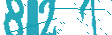

8I27


[('8IZJ', 0.21487773954868317),
 ('8IZ7', 0.09191674739122391),
 ('8LZJ', 0.07376468926668167),
 ('8IZj', 0.07185842841863632),
 ('8lZJ', 0.05868596211075783),
 ('8rZJ', 0.04382826387882233),
 ('8IZI', 0.035376012325286865),
 ('8IZl', 0.032634634524583817),
 ('8LZ7', 0.031553804874420166),
 ('8lZ7', 0.025103682652115822)]

In [10]:
from captchagen import generate_captcha, preprocess_image
from torchvision import transforms
# test model
image, captcha = generate_captcha()
display(image)
print(captcha)
image = preprocess_image(image)
x = transforms.ToTensor()(image).unsqueeze(0).to(device)
y_pred = model.predict_all_possible(x)
y_pred

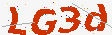

[('I43b', 0.21824529767036438),
 ('L43b', 0.1780053675174713),
 ('I43d', 0.07850442081689835),
 ('i43b', 0.07642201334238052),
 ('L43d', 0.06402982026338577),
 ('Id3b', 0.0395028181374073),
 ('Ld3b', 0.03221931681036949),
 ('i43d', 0.02748955227434635),
 ('j43b', 0.018780997022986412),
 ('I4xb', 0.014217204414308071)]

In [14]:
from captchagen import get_captcha_image
# test model on real captcha
image, cookie = get_captcha_image()
display(image)

image = preprocess_image(image)
x = transforms.ToTensor()(image).unsqueeze(0).to(device)
y_pred = model.predict_all_possible(x)
y_pred